In [1]:
lab_enc = True
ohe = False
new_features = True
hp_tune = False

In [2]:
tags = []

## Column Names and Description

In [3]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

## Librerias

In [4]:
from IPython.display import display, Markdown

import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.metrics import roc_curve, auc

# XGBoost
import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt

import itertools

from tqdm import tqdm

## Funciones

In [5]:
def plot_roc_curves(models, model_names, X_test, y_test, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:, models[i].classes_ == 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=model_names[i] + ' (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver operating characteristic example')

    plt.legend(loc="lower right")

    plt.show()

## Load Comp Data

In [6]:
comp_data = pd.read_csv("data/competition_data.csv")

In [7]:
comp_data.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días,NaN


In [8]:
comp_data.describe()

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,conversion,health,...,total_orders_item_30days,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,user_id,ROW_ID
count,199972.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,199971.000000,180761.000000,199972.000000,...,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,1.999720e+05,199972.000000,1.999720e+05,1.783750e+05,19211.000000
mean,2142.683766,333.141264,1160.099822,10815.338962,4.385187,13.542561,18.286236,0.000976,0.092631,0.809401,...,65.176297,3941.158614,29197.693135,88.487667,5238.731257,2.170257e+06,5571.603790,2.542803e+05,2.246094e+08,9605.000000
std,11326.386712,492.836951,4284.246365,26377.753704,2.768258,25.645743,33.648431,0.000154,0.289915,0.146368,...,129.610777,5145.727129,49694.994203,220.606860,6809.183739,3.545316e+06,12108.897095,3.458552e+05,1.474232e+08,5545.882346
min,0.000000,4.909057,4.773333,0.660000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,4.000000,1.000000,2.000000,3.160000e+02,1.000000,1.100000e+01,1.610000e+02,0.000000
25%,19.000000,86.729688,143.184865,793.281667,2.876796,4.188679,4.916896,0.001000,0.000000,0.770000,...,6.000000,718.000000,3938.000000,7.000000,943.000000,1.899680e+05,407.000000,4.804600e+04,1.053200e+08,4802.500000
50%,67.000000,169.234106,262.266733,2733.067000,3.639912,6.768293,8.875000,0.001000,0.000000,0.810000,...,20.000000,2102.000000,11660.000000,24.000000,2713.000000,5.613990e+05,1496.000000,1.263900e+05,1.976426e+08,9605.000000
75%,371.000000,319.281502,675.989333,9217.855667,5.066384,13.403873,18.558559,0.001000,0.000000,0.900000,...,63.000000,5017.000000,38725.000000,80.000000,6455.000000,2.007145e+06,5248.000000,2.817150e+05,3.202613e+08,14407.500000
max,99999.000000,3778.257881,57282.961233,244988.442667,38.148629,258.363636,465.500000,0.001000,1.000000,1.000000,...,1853.000000,36492.000000,505258.000000,8269.000000,56189.000000,1.591114e+07,195413.000000,2.938795e+06,1.000014e+09,19210.000000


In [9]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **accepts_mercadopago**
- **available_quantity**
- **avg_gmv_item_domain_30days**
- **avg_gmv_item_sel**
- **avg_gmv_seller_bday**
- **avg_qty_orders_item_domain_30days**
- **avg_qty_orders_item_sel_30days**
- **avg_si_item_sel_30day**
- **benefit**
- **boosted**
- **category_id**
- **conversion**
- **date**
- **deal_print_id**
- **domain_id**
- **etl_version**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **main_picture**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **print_server_timestamp**
- **qty_items_dom**
- **qty_items_sel**
- **site_id**
- **sold_quantity**
- **tags**
- **title**
- **total_asp_item_domain_30days**
- **total_asp_item_sel_30days**
- **total_gmv_domain_bday**
- **total_gmv_item_30days**
- **total_items_domain**
- **total_items_seller**
- **total_orders_domain_30days**
- **total_orders_item_30days**
- **total_orders_sel_30days**
- **total_si_domain_30days**
- **total_si_item_30days**
- **total_si_sel_30days**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **uid**
- **user_id**
- **warranty**
- **ROW_ID**

## Data Cleaning

In [10]:
comp_data = pd.read_csv("data/competition_data.csv")
comp_data = comp_data.drop(
        columns=[
            "accepts_mercadopago", # Todos tienen mercadopago
            "boosted", # Ninguno
            "avg_qty_orders_item_domain_30days",
            "avg_qty_orders_item_sel_30days",
            "avg_si_item_sel_30day",
            #"date",
            "deal_print_id",
            "etl_version",
            "full_name",
            "main_picture",
            "print_server_timestamp",
            #"title",
            "uid",
            #"user_id",
            "avg_gmv_item_domain_30days",
            #"avg_gmv_item_sel",
            "avg_gmv_seller_bday",
            #"qty_items_dom",
            #"category_id",
            #"domain_id",
            "product_id",
            #"listing_type_id",
            # "logistic_type",
            "site_id",
            #"tags",
            "total_asp_item_sel_30days", 
            "total_gmv_domain_bday", 
            #"total_items_domain", 
            "total_items_seller", 
            "total_orders_domain_30days", 
            "total_orders_item_30days", 
            "total_orders_sel_30days", 
            "total_si_sel_30days", 
            #"total_visits_domain", 
            #"total_visits_item", 
            #"total_visits_seller",
            "total_asp_item_domain_30days",
            "total_gmv_item_30days",
            "total_si_domain_30days",
            "total_si_item_30days",
            "warranty",
            # "offset",
        ]
    )

In [11]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **date**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **tags**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**

In [12]:
if len(tags) == 0:
    tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(pd.Series).stack().value_counts()

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_39184/4235516945.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(pd.Series).stack().value_counts()


In [13]:
# tags

In [14]:
# # For tag in tags, create a new column with the tag name and a boolean value
for tag in tags.index:
    comp_data[tag] = comp_data["tags"].str.contains(tag).astype(int)

comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)

comp_data = comp_data.drop("tags", axis=1)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_39184/1450897619.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)


In [15]:
# comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
# comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)

# OneHotEncoder
# comp_data = pd.get_dummies(comp_data, columns=["category_id"], dtype=int, sparse=True, dummy_na = False)
# Add category_id ohe category column if that category has more than 1000 ocurrences
# ocurrences = comp_data["category_id"].value_counts()
# for category_id in ocurrences[ocurrences > 1000].index:
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id"] == category_id
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id_" + str(category_id)].astype(int)
# comp_data = comp_data.drop(columns=["category_id"])

# comp_data = pd.get_dummies(comp_data, columns=["logistic_type"], dtype=int, sparse=True, dummy_na = False)

In [16]:
comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data["day"] = comp_data["date"].dt.day
comp_data["month"] = comp_data["date"].dt.month
#comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["year"] = comp_data["date"].dt.year
comp_data["dayofweek"] = comp_data["date"].dt.dayofweek
# comp_data["weekofyear"] = comp_data["date"].dt.isocalendar().week
#comp_data["quarter"] = comp_data["date"].dt.quarter
# comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["minute"] = comp_data["date"].dt.minute


In [17]:
comp_data["date"].min(), comp_data["date"].max()

(Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-25 00:00:00'))

In [18]:
comp_data = comp_data.drop(columns=["date"])

### Parse boolean columns

In [19]:
# comp_data["boosted"] = comp_data["boosted"].astype(int)
comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)
comp_data["is_pdp"].fillna(0, inplace=True)
comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)

comp_data["imp_user_id"] = comp_data["user_id"].isna().astype(int)
comp_data["user_id"] = comp_data["user_id"].fillna(0).astype(int)

comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

### Encoding

In [20]:
if lab_enc:
    # LabelEncoder
    comp_data["platform"] = LabelEncoder().fit_transform(comp_data["platform"]).astype(int)
    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["logistic_type"] = LabelEncoder().fit_transform(comp_data["logistic_type"]).astype(int)

if ohe:
    # OHE
    comp_data = pd.get_dummies(comp_data,
                            columns = [
                                # "platform",
                                "category_id",
                                # "domain_id"
                                ],
                            sparse = True,    # Devolver una matriz rala.
                            dummy_na = False, # No agregar columna para NaNs.
                            dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
                        )


# Encode category_id as a number, but number is based on ocurrences of category_id
# ! Has data leakage
#ocurrences = comp_data["category_id"].value_counts()
#for category_id in ocurrences.index:
#    comp_data["category_id"] = comp_data["category_id"].replace(category_id, ocurrences[category_id])

# comp_data["category_id"] = comp_data["category_id"].apply(lambda x: ocurrences[x])

### New columns

In [21]:
if new_features:
    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["price_ratio"] = comp_data["price"] / comp_data["original_price"]
    comp_data["price_ratio"] = comp_data["price_ratio"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["title_length"] = comp_data["title"].str.len()
    comp_data["title_word_count"] = comp_data["title"].str.split(" ").apply(len)

    comp_data["title_length_word_count"] = comp_data["title_length"] / comp_data["title_word_count"]
    comp_data["title_length_word_count"] = comp_data["title_length_word_count"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["domain_dominance"] = comp_data["sold_quantity"] / comp_data["qty_items_dom"]

    comp_data["is_pdp_tvi"] = comp_data["is_pdp"] / comp_data["total_visits_item"]
    comp_data["is_pdp_tvi"] = comp_data["is_pdp_tvi"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvs"] = comp_data["is_pdp"] / comp_data["total_visits_seller"]
    comp_data["is_pdp_tvs"] = comp_data["is_pdp_tvs"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvd"] = comp_data["is_pdp"] / comp_data["total_visits_domain"]
    comp_data["is_pdp_tvd"] = comp_data["is_pdp_tvd"].apply(lambda x: 1 if x == np.inf else x)


In [22]:
# comp_data = comp_data.dropna(subset=["avg_gmv_item_sel"])

# Fil nas for ["avg_gmv_item_sel", "qty_items_dom", "qty_items_sel", "domain_dominance"]

comp_data["nan_imputed"] = comp_data["avg_gmv_item_sel"].isna().astype(int)

comp_data["avg_gmv_item_sel"] = comp_data["avg_gmv_item_sel"].fillna(comp_data["avg_gmv_item_sel"].mean())
comp_data["qty_items_dom"] = comp_data["qty_items_dom"].fillna(comp_data["qty_items_dom"].mean())
comp_data["qty_items_sel"] = comp_data["qty_items_sel"].fillna(comp_data["qty_items_sel"].mean())
comp_data["domain_dominance"] = comp_data["domain_dominance"].fillna(comp_data["domain_dominance"].mean())

## Exploratory

In [23]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **immediate_payment**
- **good_quality_picture**
- **brand_verified**
- **good_quality_thumbnail**
- **cart_eligible**
- **loyalty_discount_eligible**
- **today_promotion**
- **extended_warranty_eligible**
- **ahora-12**
- **deal_of_the_day**
- **dragged_bids_and_visits**
- **incomplete_technical_specs**
- **catalog_listing_eligible**
- **lightning_deal**
- **poor_quality_picture**
- **poor_quality_thumbnail**
- **supermarket_eligible**
- **under_infractions**
- **tags_count**
- **day**
- **month**
- **dayofweek**
- **imp_is_pdp**
- **imp_user_id**
- **price_diff**
- **discount**
- **price_ratio**
- **is_discount**
- **title_length**
- **title_word_count**
- **title_length_word_count**
- **domain_dominance**
- **is_pdp_tvi**
- **is_pdp_tvs**
- **is_pdp_tvd**
- **nan_imputed**

In [24]:
# Check this columns for variance
# accepts_mercadopago
# available_quantity
# avg_gmv_item_domain_30days
# avg_gmv_item_sel
# avg_gmv_seller_bday
# avg_qty_orders_item_domain_30days
# avg_qty_orders_item_sel_30days
# avg_si_item_sel_30day
# benefit
# boosted
# category_id
# conversion
# date
# deal_print_id
# domain_id
# etl_version
# free_shipping
# fulfillment
# full_name
# health
# is_pdp
# product_id
# item_id
# listing_type_id
# logistic_type
# main_picture
# offset
# original_price
# platform
# price
# print_position
# print_server_timestamp
# qty_items_dom
# qty_items_sel
# old_quantity
# tags
# title
# total_asp_item_domain_30days
# total_asp_item_sel_30days
# total_gmv_domain_bday
# total_gmv_item_30days
# total_items_domain
# total_items_seller
# total_orders_domain_30days
# total_orders_item_30days
# total_orders_sel_30days
# total_si_domain_30days
# total_si_item_30days
# total_si_sel_30days
# total_visits_domain
# total_visits_item
# total_visits_seller
# uid
# user_id
# warranty

# for col in comp_data.columns:
#     print()
#     print(col)
#     print(comp_data[col].value_counts().head(5))

In [25]:
# comp_data.groupby("user_id")["conversion"].sum()
# comp_data[comp_data["conversion"] == True]["user_id"].value_counts()

In [26]:
# Balance conversion
# comp_data = comp_data.drop(comp_data[comp_data["conversion"] == False].sample(frac=.5).index)

In [27]:
# comp_data["conversion"].value_counts()

### Plots

In [28]:
# # Plot 'offset' vs 'category_id' . Dot color depends on 'conversion'

# plt.scatter(new_test_data["offset"], new_test_data["discount"], c=new_test_data["conversion"])

In [29]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(
#     new_test_data["offset"],
#     new_test_data["discount"],
#     new_test_data["is_pdp"],
#     c=new_test_data["conversion"],
#     # cmap="coolwarm",
#     alpha=.5
# )

# ax.set_xlabel("offset")
# ax.set_ylabel("discount")
# ax.set_zlabel("is_pdp")


In [30]:
# # Plot 'offset', 'discount', 'category_id' in 3D. Dot color depends on 'conversion'

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(
#     new_test_data["offset"],
#     new_test_data["discount"],
#     new_test_data["price_diff"],
#     c=new_test_data["conversion"],
#     # cmap="coolwarm",
#     alpha=.5
# )

# ax.set_xlabel("offset")
# ax.set_ylabel("discount")
# ax.set_zlabel("price_diff")


In [31]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# # ax = fig.add_subplot(111)
# ax.scatter(
#     new_test_data["offset"],
#     new_test_data["price_diff"],
#     new_test_data["offset"] ** 2 + new_test_data["price_diff"]**2,
#     c=new_test_data["conversion"],
# )

# plt.show()

In [32]:
# # Plot hist boosted
# plot_data = comp_data.groupby("is_pdp")["conversion"].sum()
# plot_data


In [33]:
# Plot hour vs conversion
#comp_data.groupby("dayofweek")["conversion"].mean().plot()

## Splits

### Split Comp Data -> Full | Eval

In [34]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
# del comp_data
gc.collect()

16

In [35]:
# df = pd.read_csv("data/competition_data.csv")
# print(df.isna().sum()[df.isna().sum() > 0])
# del df
# gc.collect()

In [36]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

In [37]:
# The following cols have nan values
# avg_gmv_item_sel
# qty_items_dom
# qty_items_sel
# domain_dominance depends on qty_items_dom

# For those columns, are the rows with nan values the same?

# full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_dom"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_sel"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["domain_dominance"].isna().sum()

# Yes, they are the same rows

In [38]:
# Drop those rows

# full_data = full_data.dropna(subset=["avg_gmv_item_sel"])

In [39]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

### Train Test Split

In [40]:
# Shuffle
full_data = full_data.sample(frac=1, random_state=19092140).reset_index(drop=True)

train_data, test_data = train_test_split(full_data, test_size=0.25, train_size=0.75, random_state=42)

### Balancing

In [41]:
count_converts_test = test_data[test_data["conversion"] == True].shape[0]
count_not_converts_test = test_data[test_data["conversion"] == False].shape[0]
ratio = count_converts_test / count_not_converts_test

# From test_data, keep ratio of count_not_converts_test entries

not_converts = test_data[test_data["conversion"] == False].sample(frac=ratio)

new_test_data = pd.concat([test_data[test_data["conversion"] == True], not_converts])
new_test_data["conversion"].value_counts()

1.0    4189
0.0    4189
Name: conversion, dtype: int64

In [42]:
# ! Oversample, repeats into Validation
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data["conversion"].value_counts()

###  Split X | y

In [43]:
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

0

### Validation Split

In [44]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, train_size=0.75, random_state=42)

## Models

### XGBoost

In [45]:
random_state = 12345

### Train XGBoost Model (Default params) with Cross Validation

In [46]:
xgb1_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
    #base_score=0.74
)

xgb1_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=20)

[0]	validation_0-auc:0.86482
[20]	validation_0-auc:0.88447
[40]	validation_0-auc:0.88862
[60]	validation_0-auc:0.88967
[80]	validation_0-auc:0.88988
[99]	validation_0-auc:0.88994


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### ROC AUC

In [47]:
roc_auc_score(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])

0.8915926773171863

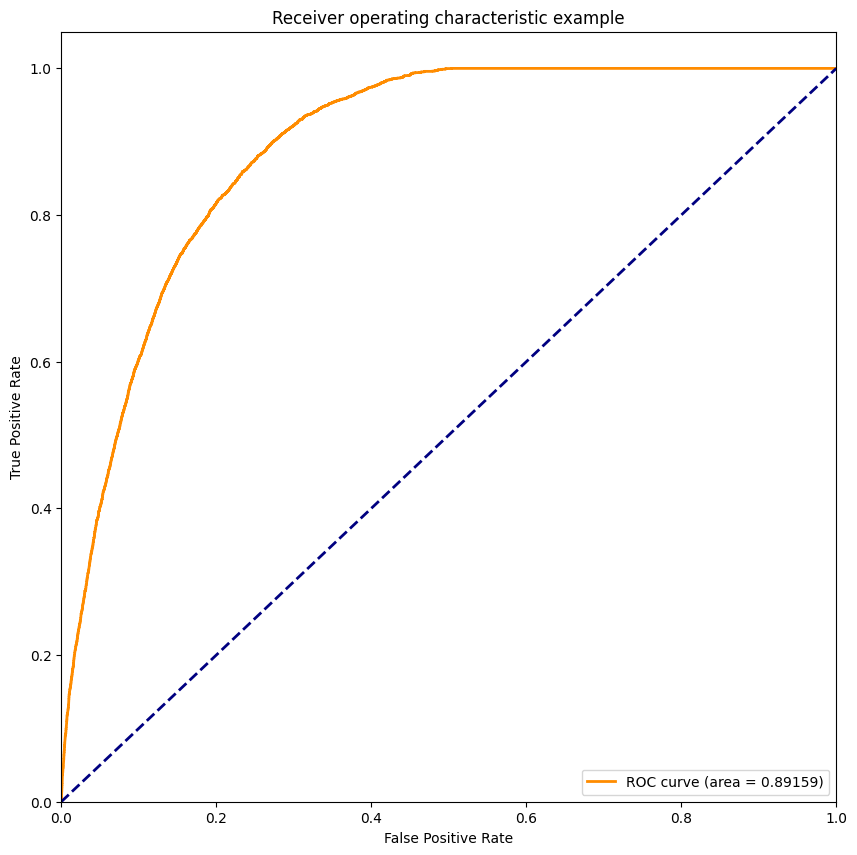

In [48]:
# Plot ROC curve

fpr, tpr, thresholds = roc_curve(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

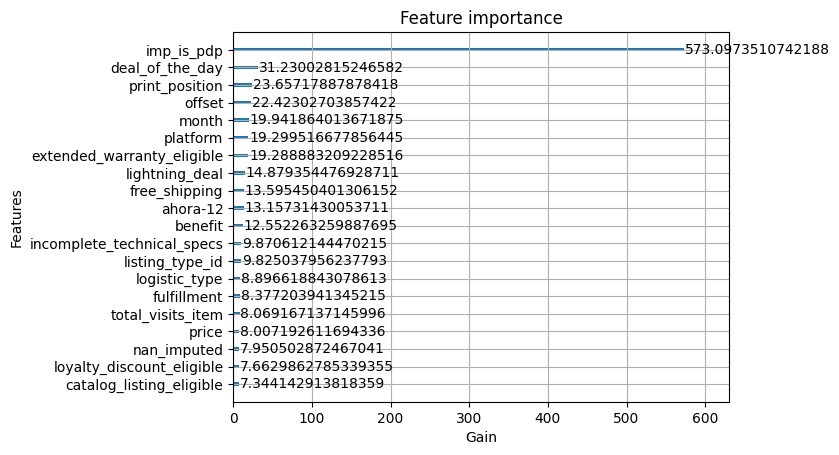

In [49]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="gain", xlabel="Gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Cover', ylabel='Features'>

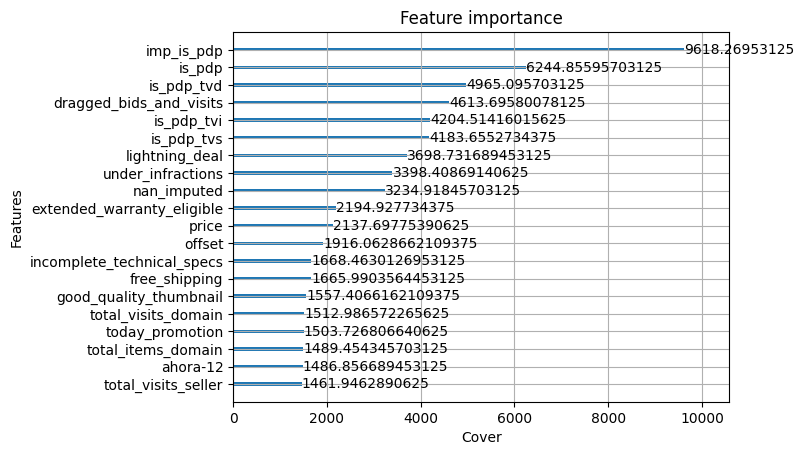

In [50]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="cover", xlabel="Cover")

#### Feature Importance

In [51]:
# Get Feature Importance from the classifier xgb1_model
feature_importances = pd.DataFrame(
    xgb1_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
imp_is_pdp,0.570538
deal_of_the_day,0.031091
print_position,0.023552
offset,0.022323
month,0.019853
platform,0.019213
extended_warranty_eligible,0.019203
lightning_deal,0.014813
free_shipping,0.013535
ahora-12,0.013099


In [52]:
# Add gain column
gains = sorted(xgb1_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)

gains_pd = pd.DataFrame(gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

gains_pd.head(20)

,gain
feature,
imp_is_pdp,573.097351
deal_of_the_day,31.230028
print_position,23.657179
offset,22.423027
month,19.941864
platform,19.299517
extended_warranty_eligible,19.288883
lightning_deal,14.879354
free_shipping,13.595450


In [53]:
feature_importances.head(20)

,importance
imp_is_pdp,0.570538
deal_of_the_day,0.031091
print_position,0.023552
offset,0.022323
month,0.019853
platform,0.019213
extended_warranty_eligible,0.019203
lightning_deal,0.014813
free_shipping,0.013535
ahora-12,0.013099


### Train XGBoost Model (Top 20 Gain params) with Cross Validation

In [54]:
xgb2_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

reduced_cols = gains_pd.head(20).index

xgb2_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [55]:
roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

0.8946293969392103

In [56]:
covers = sorted(xgb1_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
covers_pd = pd.DataFrame(covers, columns=["feature", "cover"]).set_index("feature").sort_values("cover", ascending=False)


xgb_model_covers = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

reduced_cols = covers_pd.head(20).index

xgb_model_covers.fit(X_train[reduced_cols], y_train)

roc_auc_score(y_test, xgb_model_covers.predict_proba(X_test[reduced_cols])[:, xgb_model_covers.classes_ == 1])

0.8762125607203901

#### ROC AUC

In [57]:
roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

0.8946293969392103

#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

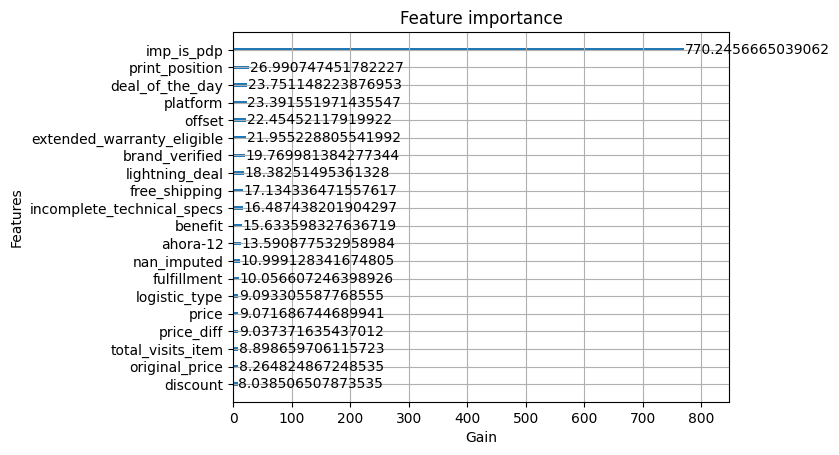

In [58]:
# Feature Importance
xgb.plot_importance(xgb2_model, max_num_features=20, importance_type="gain", xlabel="Gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

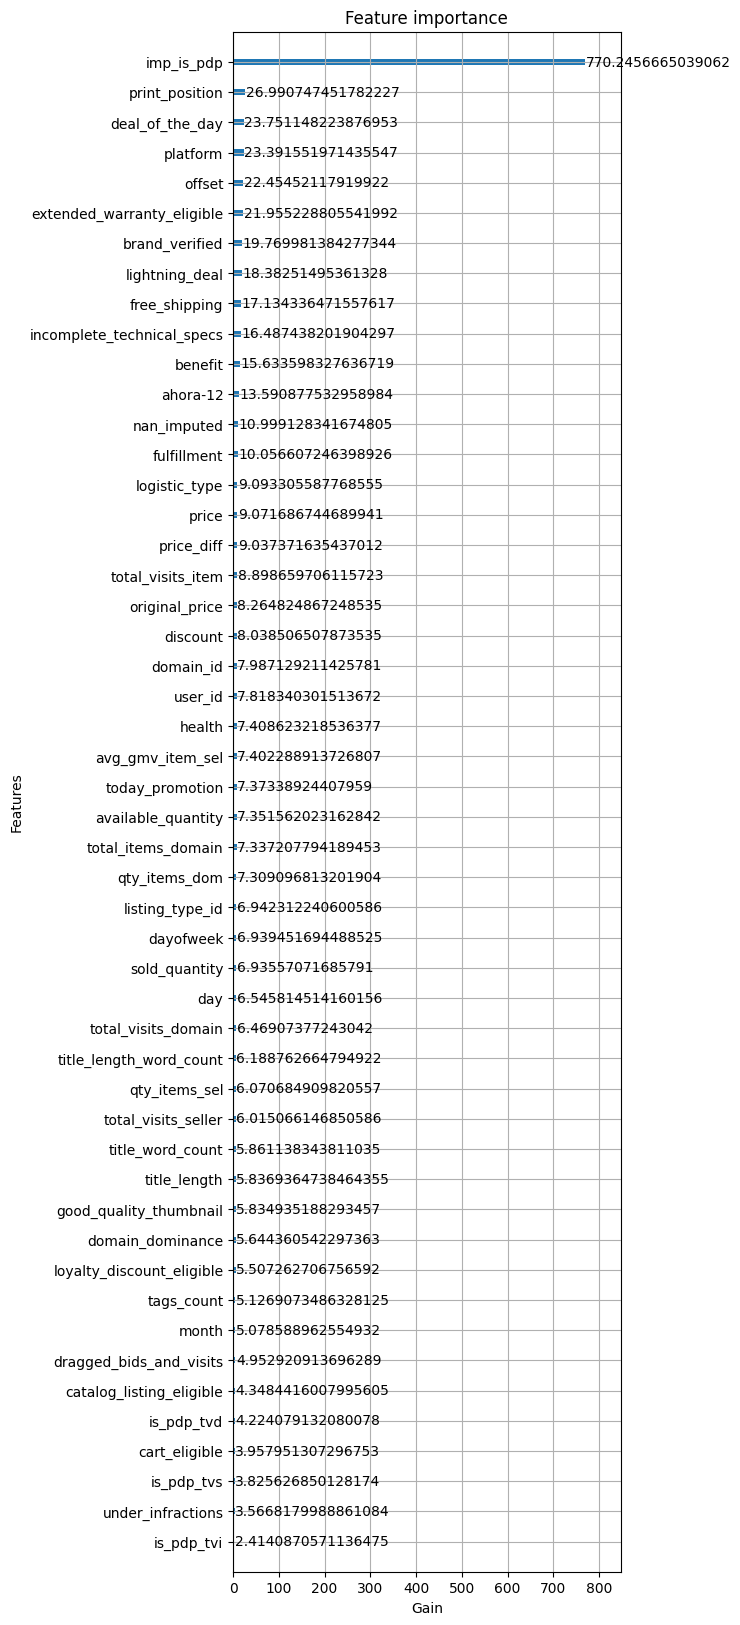

In [59]:
# Feature Importance
fig, ax = plt.subplots(figsize=(5, 20))

xgb.plot_importance(xgb2_model, max_num_features=100, importance_type="gain", xlabel="Gain", ax=ax)

## Retrain Model with Validation Data

In [60]:
# del comp_data
# del full_data
# gc.collect()

In [61]:
# params = {'colsample_bytree': 0.9958188825321641, 'gamma': 0.9488078042954764, 'learning_rate': 0.07108927605766976, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 4, 'subsample': 0.8232243201689888}
xgb4_model = xgb.XGBClassifier(
        # **params,
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
)

xgb4_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### ROC AUC on X_test

In [62]:
roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

0.8946293969392103

#### ROC AUC on Balanced X_test (Subsampled X_test for conversion == 0)

In [63]:
new_X_test = new_test_data.drop(columns=["conversion", "ROW_ID"])
new_X_test = new_X_test.select_dtypes(include='number')

new_y_test = new_test_data["conversion"]

roc_auc_score(new_y_test, xgb2_model.predict_proba(new_X_test)[:, xgb2_model.classes_ == 1])

0.9038572587289254

#### Confusion Matrix

In [64]:
# Confusion Matrix for xgb2_model on new_test_data

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(new_y_test, xgb2_model.predict(new_X_test))

true_neg, false_pos, false_neg, true_pos = conf_mx.ravel()

true_neg, false_pos, false_neg, true_pos

(4138, 51, 3418, 771)

In [65]:
""" xgb3_model = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    )
)

xgb3_model.fit(X_train, y_train)

roc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) """

' xgb3_model = make_pipeline(\n    SimpleImputer(strategy="median"),\n    xgb.XGBClassifier(\n        objective = \'binary:logistic\',\n        seed = random_state,\n        n_jobs=-1,\n    )\n)\n\nxgb3_model.fit(X_train, y_train)\n\nroc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) '

### Random Forest

In [66]:
rfc = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier()
)

rfc.fit(X_train, y_train)

roc_auc_score(y_test, rfc.predict_proba(X_test)[:, rfc.classes_ == 1])

0.8718516854629674

### Voting Classifier (XGBoost + Random Forest)

In [67]:
voting_rfc_xgb = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model)
    ],
    voting="soft",
    n_jobs=-1
)

voting_rfc_xgb.fit(X_train, y_train)

roc_auc_score(y_test, voting_rfc_xgb.predict_proba(X_test)[:, voting_rfc_xgb.classes_ == 1])

0.894871104168812

### GradientBoostingClassifier

In [68]:
gbc = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier()
)

gbc.fit(X_train, y_train)

roc_auc_score(y_test, gbc.predict_proba(X_test)[:, gbc.classes_ == 1])

0.8808407199835107

### HistGradientBoostingClassifier

In [69]:
hgb = HistGradientBoostingClassifier()

hgb.fit(X_train, y_train)

roc_auc_score(y_test, hgb.predict_proba(X_test)[:, hgb.classes_ == 1])

0.8914066794848254

### AdaBoostClassifier

In [70]:
abc = make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier()
)

abc.fit(X_train, y_train)

roc_auc_score(y_test, abc.predict_proba(X_test)[:, abc.classes_ == 1])

0.8799756275972028

### ExtraTreesClassifier

In [71]:
etc = make_pipeline(
    SimpleImputer(strategy="median"),
    ExtraTreesClassifier()
)

etc.fit(X_train, y_train)

roc_auc_score(y_test, etc.predict_proba(X_test)[:, etc.classes_ == 1])

0.841955744107831

### Voting Classifier Alt

In [72]:
voting_alt = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    voting="soft",
    n_jobs=-1
)

voting_alt.fit(X_train, y_train)

roc_auc_score(y_test, voting_alt.predict_proba(X_test)[:, voting_alt.classes_ == 1])

0.8981937241729436

In [73]:
voting_alt

VotingClassifier(estimators=[('rfc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_met...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('hgb', HistGradientBoostingClassifier()),
                             ('abc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier())]))],
                 n_jobs=-1, voting='soft')

### Average Classifier

In [74]:
# average classifier
from sklearn.utils._pprint import _EstimatorPrettyPrinter

class AverageClassifier:
    def __init__(self, models):
        self.models = models
        self.classes_ = models[0].classes_

    def predict_proba(self, X):
        return np.mean([model.predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.mean([model.predict(X) for model in self.models], axis=0)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        # Using _EstimatorPrettyPrinter

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW,
        )

        repr_ = pp.pformat(self)

        return repr_
        


average_classifier = AverageClassifier([rfc, xgb4_model, hgb, abc, voting_alt])

# average_classifier.fit(X_train, y_train)

roc_auc_score(y_test, average_classifier.predict_proba(X_test)[:, average_classifier.classes_ == 1])

0.8984135080357362

### Stacking Classifier

In [75]:
# Stacking Classifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_classifier = StackingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_classifier.fit(X_train, y_train)

roc_auc_score(y_test, stacking_classifier.predict_proba(X_test)[:, stacking_classifier.classes_ == 1])

0.8973230745290022

In [76]:
stacking_classifier

StackingClassifier(estimators=[('rfc',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())])),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_m...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('hgb', HistGradientBoostingClassifier()),
                               ('abc',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('adaboostclassifier',
                                                 AdaBoostClassifier())]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [77]:
average_classifier2 = AverageClassifier([voting_alt, stacking_classifier])

average_classifier.fit(X_train, y_train)

roc_auc_score(y_test, average_classifier2.predict_proba(X_test)[:, average_classifier2.classes_ == 1])

0.898373955149688

### Logistic Regression

In [78]:
# Logistic Regression

logistic_regression = make_pipeline(
    SimpleImputer(strategy="median"),
    LogisticRegression(
        n_jobs=-1
    )
)

best_score = 0
best_cut = 0
for i in range(1, 20):

    logistic_regression.fit(X_train[reduced_cols[:i]], y_train)

    score = roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:i]])[:, logistic_regression.classes_ == 1])

    print(i, score)

    if score > best_score:
        best_score = score
        best_cut = i

best_score, best_cut

1 0.7475854836349447
2 0.7500072427747471
3 0.75001153080015
4 0.7493373210436409
5 0.7492671406523217
6 0.7492670824306598
7 0.7494999225011458
8 0.7499480400777893
9 0.752923548355518
10 0.7719187178090248
11 0.7749069970083032
12 0.8290116626023483
13 0.828472040950695


/Users/nacho/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


14 0.8409991534686796
15 0.8420297059960941
16 0.6484310414892338
17 0.648432237944387
18 0.6458436329879232
19 0.6458444626466062


(0.8420297059960941, 15)

In [79]:
logistic_regression = make_pipeline(
    SimpleImputer(strategy="median"),
    LogisticRegression(
        n_jobs=-1,
        max_iter=1000
    )
)

logistic_regression.fit(X_train[reduced_cols[:best_cut]], y_train)

roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:best_cut]])[:, logistic_regression.classes_ == 1])

0.8420297059960941

#### ROC AUC Curves

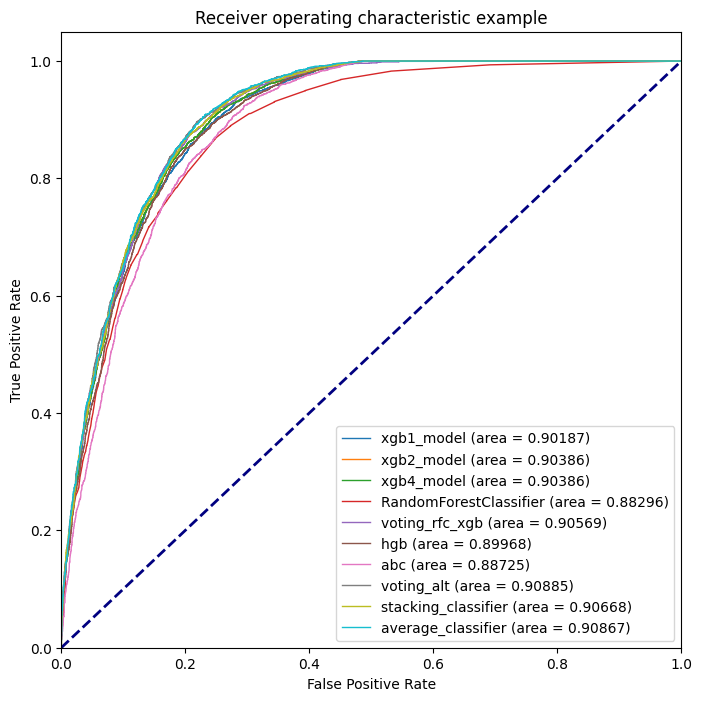

In [80]:
models = [
    (xgb1_model, "xgb1_model"),
    (xgb2_model, "xgb2_model"),
    (xgb4_model, "xgb4_model"), 
    (rfc, "RandomForestClassifier"),
    (voting_rfc_xgb, "voting_rfc_xgb"), 
    #(gbc, "gbc"), 
    (hgb, "hgb"),
    (abc, "abc"), 
    # (etc, "etc"), 
    (voting_alt, "voting_alt"),
    (stacking_classifier, "stacking_classifier"),
    (average_classifier, "average_classifier")
]

model_names = [model[1] for model in models]
models = [model[0] for model in models]

fig, ax = plt.subplots(figsize=(8, 8))

plot_roc_curves(models, model_names, new_X_test, new_y_test, ax=ax)

fig.tight_layout()

## Hyperopt for XGBoost Model

In [81]:
# XGBoost with Hyperopt
if hp_tune:

    xgb_space = {
        "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
        "subsample": hp.uniform("subsample", 0.5, 1),
    }

    best_score = 0
    def objective_xgb(params):
        global best_score

        model = xgb.XGBClassifier(
            **params,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            #eval_metric = 'auc',
        )
        
        score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

        #model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=0)
        #model.fit(X_train, y_train)
        #score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

        # print(f"Score: {score}", params)

        # if score > best_score:
        #     best_score = score
        #     print(f"New best score: {best_score}")
        #     print(params)
            
        return {"loss": 1 - score, "status": STATUS_OK}

    trials_xgb = Trials()

    best_xgb = fmin(
        fn=objective_xgb,
        space=xgb_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        verbose=2,
    )

    print(best_xgb)

In [82]:
p = {'colsample_bytree': 0.5261530316412195, 'gamma': 0.4666423706737293, 'learning_rate': 0.043284110571295886, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.8142370483321494}
model = xgb.XGBClassifier(
    **p,
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
    #eval_metric = 'auc',
)

#score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

0.8491963850309825

## Create Submission

In [87]:
final_classifier = AverageClassifier([voting_alt, stacking_classifier])

X_full = full_data.drop(columns=["conversion", "ROW_ID"])
X_full = X_full.select_dtypes(include='number')

y_full = full_data["conversion"]

final_classifier.fit(X_full, y_full)

# Should be 1
roc_auc_score(y_test, final_classifier.predict_proba(X_test)[:, final_classifier.classes_ == 1])

0.9831288004408173

In [88]:
from sklearn.utils._pprint import _EstimatorPrettyPrinter

In [91]:
feature_cols = xgb4_model.get_booster().feature_names

#final_classifier.models[1].get_booster().feature_names
#feature_cols

In [92]:
model = final_classifier

eval_data = comp_data[comp_data["ROW_ID"].notna()]
# del comp_data

# Predict on the evaluation set
# eval_data = eval_data.drop(columns=["conversion"])
eval_data = eval_data.select_dtypes(include='number')
y_preds = model.predict_proba(eval_data[feature_cols])[:, model.classes_ == 1].squeeze()

# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("los_simuladores_average_classifier_imputed.csv", index=False)

del eval_data
del submission_df
gc.collect()

2649